<a href="https://colab.research.google.com/github/shubh-ag/PHI/blob/master/PHI_separate_stress_types_4Hz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/shubh-ag/PHI

Cloning into 'PHI'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 145 (delta 30), reused 118 (delta 21), pack-reused 0
Receiving objects: 100% (145/145), 17.19 MiB | 8.10 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (93/93), done.


In [2]:
#IMPORTS
import pandas as pd
import numpy as np
import os
from pandas import read_csv
import statistics
from sklearn.model_selection import train_test_split
import datetime
from datetime import timedelta
from pytz import timezone
import pytz

In [3]:
def load_utd_data():  
  # Create data frame using EDA data
  data = []
  for i in os.listdir():
    temp = read_csv(i+"/"+i+"AccTempEDA.csv")
    temp = temp.drop(['Hour','Minute','Second'], axis=1)
    
    hr = read_csv(i+"/"+i+"SpO2HR.csv")
    hr = hr[['HeartRate']]
    
    interval = 8 #4Hz and we combine data for 2 secs
    subject_data = []
    person_min = np.amin(temp.to_numpy()[:,:-1], axis = 0).astype(float)
    person_max = np.amax(temp.to_numpy()[:,:-1], axis = 0).astype(float)

    person_hr_min = min(hr.values)[0]
    person_hr_max = max(hr.values)[0]
    c = 0
    for j in range(0, len(temp) - interval, interval):
      d = temp[j:j+interval]
      d_np = d.to_numpy()[:,:-1]
      d_hr = hr[c:c+2]
      c = c+2
      d_hr = d_hr.to_numpy()
      
      minimum = (np.amin(d_np, axis = 0).astype(float) -person_min)/ (person_max - person_min)
      maximum = (np.amax(d_np, axis = 0).astype(float) -person_min)/ (person_max - person_min)
      average = (np.average(d_np, axis = 0).astype(float) -person_min)/ (person_max - person_min)
      
      values, counts = np.unique(d['Label'], return_counts=True)
      mode = values[np.argmax(counts)]
      df = []
      df.extend(np.around(minimum, decimals=4))
      df.append((np.amin(d_hr, axis=0).astype(float)[0] - person_hr_min) / (person_hr_max - person_hr_min))
      df.extend(np.around(maximum, 4))
      df.append((np.amax(d_hr, axis=0).astype(float)[0] - person_hr_min) / (person_hr_max - person_hr_min))
      df.extend(np.around(average, 4))
      df.append((np.average(d_hr, axis=0).astype(float)[0] - person_hr_min) / (person_hr_max - person_hr_min))

      df.append(mode)
      subject_data.append(np.nan_to_num(df))
      if(c >= len(hr)):
        break
    
    # z_scores = []
    # for c in range(len(subject_data[0])):
    #   # print(len(subject_data[:,c]))
    #   # print(np.average(subject_data[:, c]))
    #   print(len((subject_data[:,c] - np.average(subject_data[:, c])) / np.std(subject_data[:,c])))
    # # (df[col] - df[col].mean())/df[col].std(ddof=0)
    data.extend(subject_data)



  df = pd.DataFrame(data, columns=["min_acc_z","min_acc_x","min_acc_y","min_temp", "min_eda", "min_hr",
                              "max_acc_z","max_acc_x","max_acc_y","max_temp", "max_eda", "max_hr",
                              "avg_acc_z","avg_acc_x","avg_acc_y","avg_temp", "avg_eda", "avg_hr",
                              "label"])
  return df

In [4]:
%cd /content/PHI/data/utd
df = load_utd_data()

# df = df.drop([
#               "min_acc_z",
#               "min_acc_x",
#               "min_acc_y",
#               # "min_temp", 
#               # "min_eda", 
#               # "min_hr",
#               # "max_acc_z",
#               # "max_acc_x",
#               # "max_acc_y",
#               # "max_temp", 
#               # "max_eda",
#               # "max_hr",
#               # "avg_acc_z",
#               # "avg_acc_x",
#               # "avg_acc_y",
#               # "avg_temp",
#               # "avg_eda",
#               # "avg_hr"
#               ], axis=1)

df_y = df['label']
df_x = df.drop(['label'], axis=1)

X_train, X_test, y_train, y_test  = train_test_split(df_x, df_y, test_size=0.2)
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

/content/PHI/data/utd
18496
4624
18496
4624


In [5]:
df['label'].value_counts()

Relax              11999
PhysicalStress      6525
CognitiveStress     3796
EmotionalStress      800
Name: label, dtype: int64

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from sklearn import svm

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


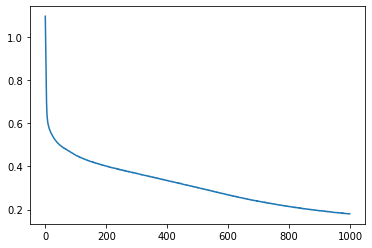

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.9450673453723802


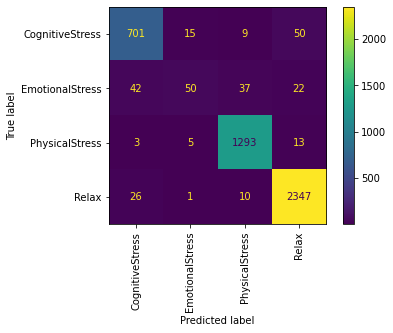

In [7]:
clf = MLPClassifier(random_state=1, max_iter=1000, activation='logistic', n_iter_no_change=100, tol=1e-24, early_stopping=True).fit(X_train.values, y_train)

plt.plot(clf.loss_curve_)
plt.show()
y_pred = clf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')




/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


0.8782099846455818


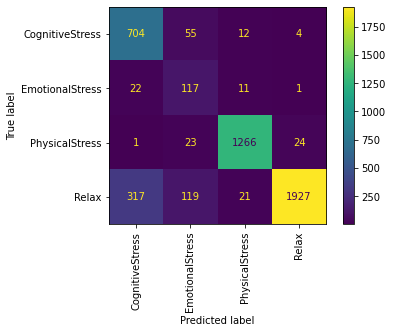

In [8]:
svm_clf = svm.SVC(class_weight='balanced').fit(X_train.values, y_train)

# plt.plot(svm_clf.loss_curve_)
# plt.show()
y_pred = svm_clf.predict(X_test)
print(f1_score(y_test, y_pred, average='weighted'))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')



In [9]:
def load_samsung_gear_data():
  data = []
  for i in os.listdir():
    eda = read_csv(i+"/EDA.csv")
    acc = read_csv(i+"/ACC.csv")
    temp = read_csv(i+"/TEMP.csv")
    hr = read_csv(i+"/HR.csv")

    time = datetime.datetime.fromtimestamp(float(eda.columns[0]), timezone('US/Eastern'))

    eda_frequency = float(eda.values[0])
    eda = eda[1:]
    acc_frequency = float(acc.values[0][0])
    acc = acc[1:]
    temp_frequency = float(temp.values[0])
    temp = temp[1:]
    hr_frequency = float(hr.values[0])
    hr = hr[1:]
    
    combine_secs = 2
    
    number_of_eda = eda_frequency * combine_secs
    length_eda = int(len(eda.values) / number_of_eda)

    number_of_acc = acc_frequency * combine_secs
    length_acc = int(len(acc.values) / number_of_acc)

    number_of_temp = temp_frequency * combine_secs
    length_temp = int(len(temp.values) / number_of_temp)
    
    number_of_hr = hr_frequency * combine_secs
    length_hr = int(len(hr.values) / number_of_hr)
    
    subject_data = []
    
    minimum_length = min(length_eda, length_acc, length_temp, length_hr)

    for j in range(minimum_length):
      time = time+timedelta(seconds=combine_secs)

      data_eda = eda[int(number_of_eda*j) : int(number_of_eda*j + number_of_eda)]
      data_acc = acc[int(number_of_acc*j) : int(number_of_acc*j + number_of_acc)]
      data_temp = temp[int(number_of_temp*j) : int(number_of_temp*j + number_of_temp)]
      data_hr = hr[int(number_of_hr*j) : int(number_of_hr*j + number_of_hr)]

      e = data_eda.to_numpy()
      a = data_acc.to_numpy()
      t = data_temp.to_numpy()
      h = data_hr.to_numpy()

      min_e = np.amin(e, axis=0).astype(float)
      max_e = np.amax(e, axis=0).astype(float)
      avg_e = np.average(e, axis=0).astype(float)
      
      min_a = np.amin(a, axis=0).astype(float)
      max_a = np.amax(a, axis=0).astype(float)
      avg_a = np.average(a, axis=0).astype(float)

      min_t = np.amin(t, axis=0).astype(float)
      max_t = np.amax(t, axis=0).astype(float)
      avg_t = np.average(t, axis=0).astype(float)

      min_h = np.amin(h, axis=0).astype(float)
      max_h = np.amax(h, axis=0).astype(float)
      avg_h = np.average(h, axis=0).astype(float)

      df = [time]
      
      df.extend(np.around(min_a, decimals=4))
      df.extend(np.around(min_t, decimals=4))
      df.extend(np.around(min_e, decimals=4))
      df.extend(np.around(min_h, decimals=4))

      df.extend(np.around(max_a, decimals=4))
      df.extend(np.around(max_t, decimals=4))
      df.extend(np.around(max_e, decimals=4))
      df.extend(np.around(max_h, decimals=4))

      df.extend(np.around(avg_a, decimals=4))
      df.extend(np.around(avg_t, decimals=4))
      df.extend(np.around(avg_e, decimals=4))
      df.extend(np.around(avg_h, decimals=4))

      subject_data.append(np.nan_to_num(df))
    data.extend(subject_data)

  df = pd.DataFrame(data, columns=["Timestamp", "min_acc_z","min_acc_x","min_acc_y","min_temp", "min_eda", "min_hr",
                              "max_acc_z","max_acc_x","max_acc_y","max_temp", "max_eda", "max_hr",
                              "avg_acc_z","avg_acc_x","avg_acc_y","avg_temp", "avg_eda", "avg_hr"])
  return df

In [10]:
%cd /content/PHI/data/samsug_gear/
test_data = load_samsung_gear_data()

data_to_normalize = test_data[["min_acc_z","min_acc_x","min_acc_y","min_temp", "min_eda", "min_hr",
                              "max_acc_z","max_acc_x","max_acc_y","max_temp", "max_eda", "max_hr",
                              "avg_acc_z","avg_acc_x","avg_acc_y","avg_temp", "avg_eda", "avg_hr"]]

data_to_normalize=(data_to_normalize - data_to_normalize.min())/(data_to_normalize.max()-data_to_normalize.min())

test_data[["min_acc_z","min_acc_x","min_acc_y","min_temp", "min_eda", "min_hr",
                              "max_acc_z","max_acc_x","max_acc_y","max_temp", "max_eda", "max_hr",
                              "avg_acc_z","avg_acc_x","avg_acc_y","avg_temp", "avg_eda", "avg_hr"]] = data_to_normalize[["min_acc_z","min_acc_x","min_acc_y","min_temp", "min_eda", "min_hr",
                              "max_acc_z","max_acc_x","max_acc_y","max_temp", "max_eda", "max_hr",
                              "avg_acc_z","avg_acc_x","avg_acc_y","avg_temp", "avg_eda", "avg_hr"]]

# test_data = test_data.drop([
#               "min_acc_z",
#               "min_acc_x",
#               "min_acc_y",
#               # "min_temp", 
#               # "min_eda", 
#               # "min_hr",
#               # "max_acc_z",
#               # "max_acc_x",
#               # "max_acc_y",
#               # "max_temp", 
#               # "max_eda",
#               # "max_hr",
#               # "avg_acc_z",
#               # "avg_acc_x",
#               # "avg_acc_y",
#               # "avg_temp",
#               # "avg_eda",
#               # "avg_hr"
#                             ], axis=1)
test_data

/content/PHI/data/samsug_gear


,Timestamp,min_acc_z,min_acc_x,min_acc_y,min_temp,min_eda,min_hr,max_acc_z,max_acc_x,max_acc_y,max_temp,max_eda,max_hr,avg_acc_z,avg_acc_x,avg_acc_y,avg_temp,avg_eda,avg_hr
0,2022-03-16 13:26:45-04:00,0.370370,0.546875,0.518325,0.676056,0.000000,0.214552,0.062827,0.221053,0.194595,0.674984,0.010719,0.231129,0.102109,0.295313,0.270385,0.67552,0.009120,0.212606
1,2022-03-16 13:26:47-04:00,0.354497,0.468750,0.528796,0.673496,0.000187,0.097948,0.115183,0.210526,0.286486,0.673704,0.010756,0.113465,0.110498,0.227030,0.348799,0.67360,0.009368,0.093950
2,2022-03-16 13:26:49-04:00,0.343915,0.489583,0.560209,0.672215,0.010980,0.074627,0.078534,0.189474,0.313514,0.672425,0.010940,0.052963,0.094079,0.236316,0.382941,0.67232,0.011016,0.051706
3,2022-03-16 13:26:51-04:00,0.343915,0.484375,0.591623,0.670935,0.011205,0.081250,0.068063,0.178947,0.291892,0.671145,0.011049,0.064128,0.096836,0.227685,0.410205,0.67104,0.011179,0.060690
4,2022-03-16 13:26:53-04:00,0.291005,0.489583,0.502618,0.670935,0.000076,0.095336,0.099476,0.257895,0.335135,0.672425,0.011049,0.078443,0.081615,0.250082,0.423461,0.67168,0.009782,0.075074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34573,2022-03-15 14:07:44-04:00,0.333333,0.807292,0.628272,0.855314,0.014988,0.503265,0.277487,0.721053,0.524324,0.855406,0.015053,0.488596,0.249880,0.775920,0.671710,0.85536,0.015125,0.489439
34574,2022-03-15 14:07:46-04:00,0.603175,0.968750,0.701571,0.851472,0.014800,0.502985,0.303665,0.705263,0.378378,0.850928,0.014574,0.488024,0.437919,0.889544,0.556403,0.85120,0.014755,0.489009
34575,2022-03-15 14:07:48-04:00,0.613757,0.989583,0.696335,0.851472,0.014727,0.502612,0.298429,0.673684,0.356757,0.852847,0.014499,0.488310,0.444151,0.889872,0.541020,0.85216,0.014714,0.488961
34576,2022-03-15 14:07:50-04:00,0.592593,0.984375,0.701571,0.850192,0.014689,0.503731,0.293194,0.668421,0.362162,0.849008,0.014465,0.490028,0.439478,0.888888,0.547648,0.84960,0.014653,0.490395


In [11]:
test_data = test_data.sort_values(by=['Timestamp'])
test_data

,Timestamp,min_acc_z,min_acc_x,min_acc_y,min_temp,min_eda,min_hr,max_acc_z,max_acc_x,max_acc_y,max_temp,max_eda,max_hr,avg_acc_z,avg_acc_x,avg_acc_y,avg_temp,avg_eda,avg_hr
13533,2022-03-14 16:33:43-04:00,0.603175,0.682292,0.979058,0.865557,0.000000,0.121269,0.314136,0.394737,0.675676,0.864363,0.011782,0.183414,0.445470,0.491424,0.980490,0.86496,0.010131,0.140925
13534,2022-03-14 16:33:45-04:00,0.576720,0.692708,0.958115,0.865557,0.011916,0.158582,0.303665,0.426316,0.675676,0.865643,0.011857,0.171486,0.422938,0.534906,0.973987,0.86560,0.011954,0.154067
13535,2022-03-14 16:33:47-04:00,0.587302,0.666667,0.968586,0.866837,0.012027,0.195896,0.282723,0.384211,0.659459,0.865643,0.011894,0.189808,0.428331,0.504315,0.975363,0.86624,0.012041,0.182357
13536,2022-03-14 16:33:49-04:00,0.550265,0.630208,0.947644,0.865557,0.011878,0.221175,0.282723,0.357895,0.670270,0.864363,0.011782,0.208417,0.391539,0.443898,0.973487,0.86496,0.011884,0.204626
13537,2022-03-14 16:33:51-04:00,0.566138,0.651042,0.979058,0.865557,0.011729,0.236287,0.240838,0.331579,0.643243,0.866923,0.011674,0.220632,0.369128,0.437671,0.965983,0.86624,0.011770,0.218484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24193,2022-03-16 21:43:36-04:00,0.481481,0.364583,0.837696,0.635083,0.000076,0.387873,0.460733,0.331579,0.897297,0.687780,0.000146,0.373032,0.503715,0.236862,0.921710,0.66144,0.000102,0.372455
24194,2022-03-16 21:43:38-04:00,0.698413,0.343750,0.842932,0.597951,0.000038,0.391791,0.549738,0.326316,0.702703,0.612284,0.000183,0.375227,0.714885,0.236644,0.919335,0.60512,0.000108,0.375562
24195,2022-03-16 21:43:40-04:00,0.645503,0.411458,0.685864,0.544174,0.000076,0.393657,0.722513,0.357895,0.745946,0.563660,0.000183,0.377326,0.748561,0.280892,0.896948,0.55392,0.000122,0.377569
24196,2022-03-16 21:43:42-04:00,0.915344,0.515625,0.649215,0.588988,0.000076,0.395989,0.785340,0.473684,0.556757,0.724888,0.001359,0.379807,0.997723,0.448159,0.624812,0.65696,0.000437,0.380006


In [12]:
test_data_without_ts = test_data
if('Prediction' in test_data.columns):
  test_data_without_ts = test_data_without_ts.drop(columns=['Prediction'])

if('Timestamp' in test_data.columns):
  test_data_without_ts = test_data_without_ts.drop(columns=['Timestamp'])



predictions = svm_clf.predict(test_data_without_ts.values)
print(predictions)
test_data['Prediction'] = predictions
test_data
# print(f1_score(y_test, y_pred, average='weighted'))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')

['Relax' 'Relax' 'Relax' ... 'Relax' 'Relax' 'EmotionalStress']


,Timestamp,min_acc_z,min_acc_x,min_acc_y,min_temp,min_eda,min_hr,max_acc_z,max_acc_x,max_acc_y,max_temp,max_eda,max_hr,avg_acc_z,avg_acc_x,avg_acc_y,avg_temp,avg_eda,avg_hr,Prediction
13533,2022-03-14 16:33:43-04:00,0.603175,0.682292,0.979058,0.865557,0.000000,0.121269,0.314136,0.394737,0.675676,0.864363,0.011782,0.183414,0.445470,0.491424,0.980490,0.86496,0.010131,0.140925,Relax
13534,2022-03-14 16:33:45-04:00,0.576720,0.692708,0.958115,0.865557,0.011916,0.158582,0.303665,0.426316,0.675676,0.865643,0.011857,0.171486,0.422938,0.534906,0.973987,0.86560,0.011954,0.154067,Relax
13535,2022-03-14 16:33:47-04:00,0.587302,0.666667,0.968586,0.866837,0.012027,0.195896,0.282723,0.384211,0.659459,0.865643,0.011894,0.189808,0.428331,0.504315,0.975363,0.86624,0.012041,0.182357,Relax
13536,2022-03-14 16:33:49-04:00,0.550265,0.630208,0.947644,0.865557,0.011878,0.221175,0.282723,0.357895,0.670270,0.864363,0.011782,0.208417,0.391539,0.443898,0.973487,0.86496,0.011884,0.204626,Relax
13537,2022-03-14 16:33:51-04:00,0.566138,0.651042,0.979058,0.865557,0.011729,0.236287,0.240838,0.331579,0.643243,0.866923,0.011674,0.220632,0.369128,0.437671,0.965983,0.86624,0.011770,0.218484,Relax
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24193,2022-03-16 21:43:36-04:00,0.481481,0.364583,0.837696,0.635083,0.000076,0.387873,0.460733,0.331579,0.897297,0.687780,0.000146,0.373032,0.503715,0.236862,0.921710,0.66144,0.000102,0.372455,PhysicalStress
24194,2022-03-16 21:43:38-04:00,0.698413,0.343750,0.842932,0.597951,0.000038,0.391791,0.549738,0.326316,0.702703,0.612284,0.000183,0.375227,0.714885,0.236644,0.919335,0.60512,0.000108,0.375562,Relax
24195,2022-03-16 21:43:40-04:00,0.645503,0.411458,0.685864,0.544174,0.000076,0.393657,0.722513,0.357895,0.745946,0.563660,0.000183,0.377326,0.748561,0.280892,0.896948,0.55392,0.000122,0.377569,Relax
24196,2022-03-16 21:43:42-04:00,0.915344,0.515625,0.649215,0.588988,0.000076,0.395989,0.785340,0.473684,0.556757,0.724888,0.001359,0.379807,0.997723,0.448159,0.624812,0.65696,0.000437,0.380006,Relax


In [13]:
print(test_data['Timestamp'].values[0])

2022-03-14T20:33:43.000000000


In [28]:
def convertToDate(row, columnName):
    return row[columnName].strftime("%Y-%m-%d")

def convertToTime(row, columnName):
    return row[columnName].strftime("%Y-%m-%d %H-%M")

def collapse_by(df, interval):
    values = []
    relax = 0
    es = 0
    ps = 0
    cs = 0
    orig_interval = 0
    for i in df.values:
      if(orig_interval == 0):
        orig_interval = i[0]
      elif((i[0] - orig_interval).total_seconds() >= interval):
        orig_interval = i[0]
        total_points = ps + es + cs + relax
        if(total_points == 0):
          continue
        if(es >= total_points*1/5):
          mode = 'EmotionalStress'
        elif(ps >= total_points*3/4):
          mode = 'PhysicalStress'
        elif(cs >= total_points*3/4):
          mode = 'CognitiveStress'
        else:
          mode= 'Relax'  
        values.append([orig_interval, mode])
        ps=0
        es=0
        cs=0
        relax=0
      elif(i[1] == 'PhysicalStress'):
        ps+=1
      elif(i[1] == 'CognitiveStress'):
        cs+=1
      elif(i[1] == 'EmotionalStress'):
        es+=1
      else:
        relax+=1
    return pd.DataFrame(values, columns=['Timestamp', 'Prediction'])
    # print(values)

In [52]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_by_date(d, dateStr):
  fig, ax = plt.subplots(figsize=(15,10))
  ax1 = ax.twinx()
  
  d['date'] = d.apply(convertToDate, columnName='Timestamp', axis=1)
  filtered_data = d[d['date'] == dateStr]
  
  ax.plot(filtered_data['Timestamp'].values, filtered_data['avg_eda'], color='purple', label='EDA')
  ax1.plot(filtered_data['Timestamp'].values, filtered_data['avg_hr'], color='black', label='Heart Rate')

  d['Time'] = d.apply(convertToTime, columnName='Timestamp', axis=1)
  
  filtered_data = filtered_data.sort_values(by=['Timestamp'])
  collapsed_data = collapse_by(d[['Timestamp', 'Prediction']], 90)

  ps = collapsed_data[collapsed_data['Prediction'] == 'PhysicalStress']
  plt.vlines(x = ps['Timestamp'].values, ymin = 0, ymax = 2,
            colors = 'red',
            label = 'Physical Stress')

  cs = collapsed_data[collapsed_data['Prediction'] == 'CognitiveStress']
  plt.vlines(x = cs['Timestamp'].values, ymin = 0, ymax = 2,
            colors = 'blue',
            label = 'Cognitive Stress')

  es = collapsed_data[collapsed_data['Prediction'] == 'EmotionalStress']
  plt.vlines(x = es['Timestamp'].values, ymin = 0, ymax = 2,
            colors = 'green',
            label = 'Emotional Stress')
  plt.gca().xaxis_date('US/Eastern')
  fig.tight_layout()
  ax.legend(loc="upper left")
  ax.set_xlabel('Date & Time (mm-dd hh)')
  ax.set_ylabel('Normalized EDA')
  ax1.set_ylabel('Normalized Heart Rate')
  ax1.legend(loc=1)
  plt.show()
  

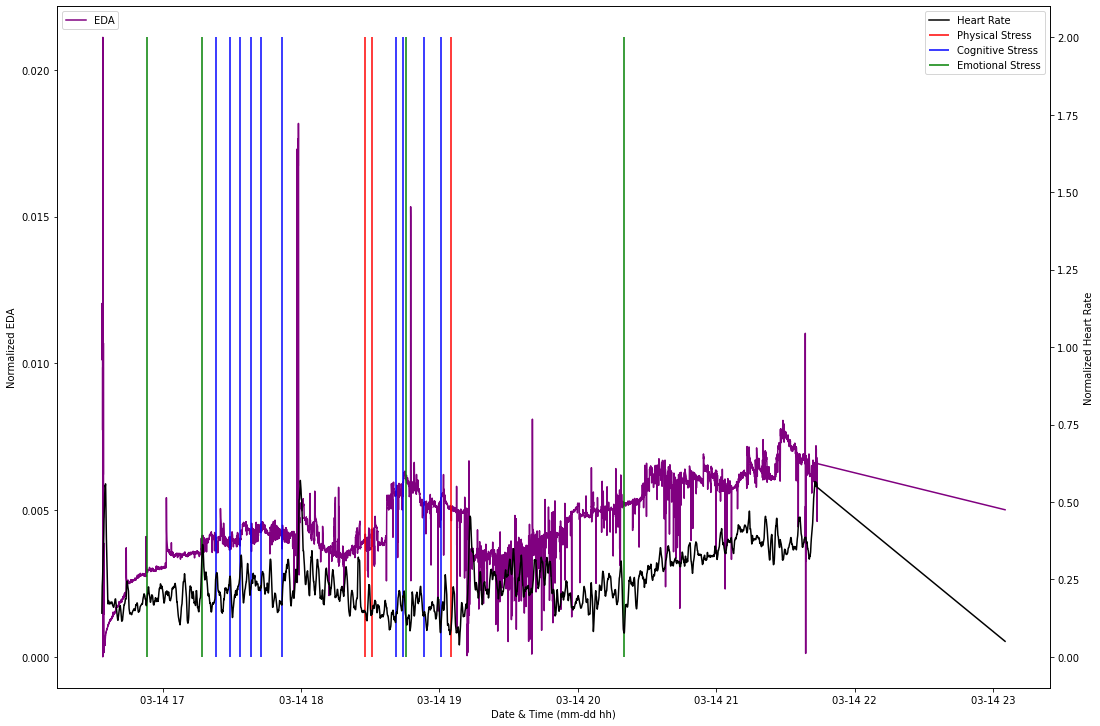

In [53]:
plot_by_date(test_data, '2022-03-14')

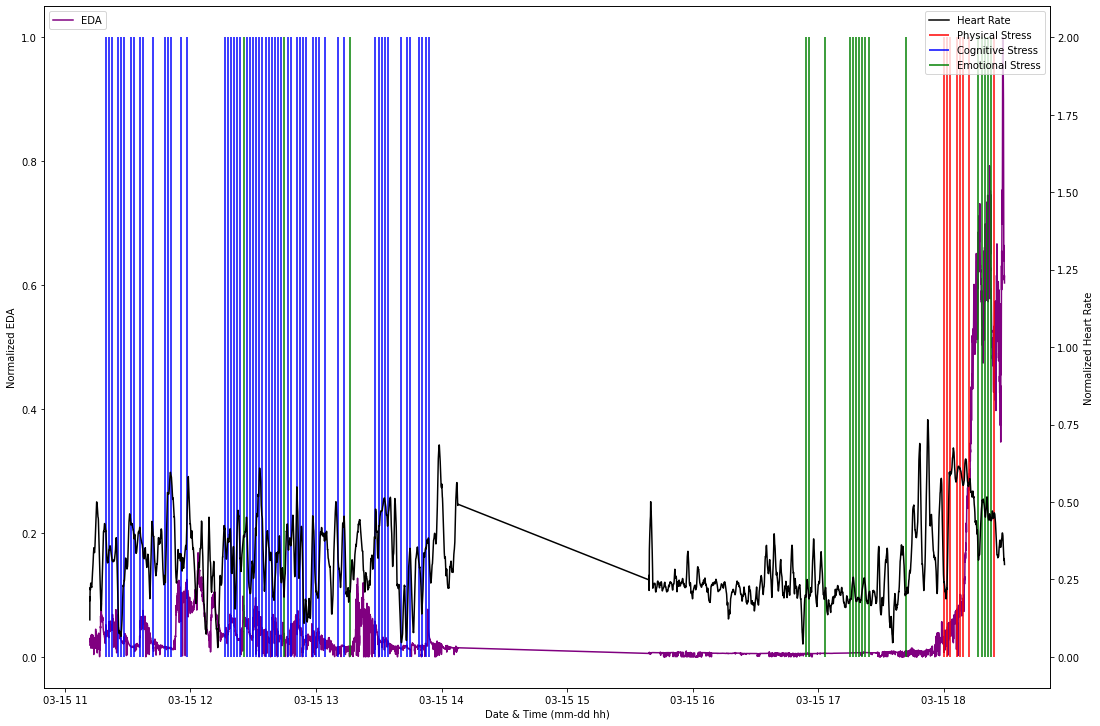

In [54]:
plot_by_date(test_data, '2022-03-15')

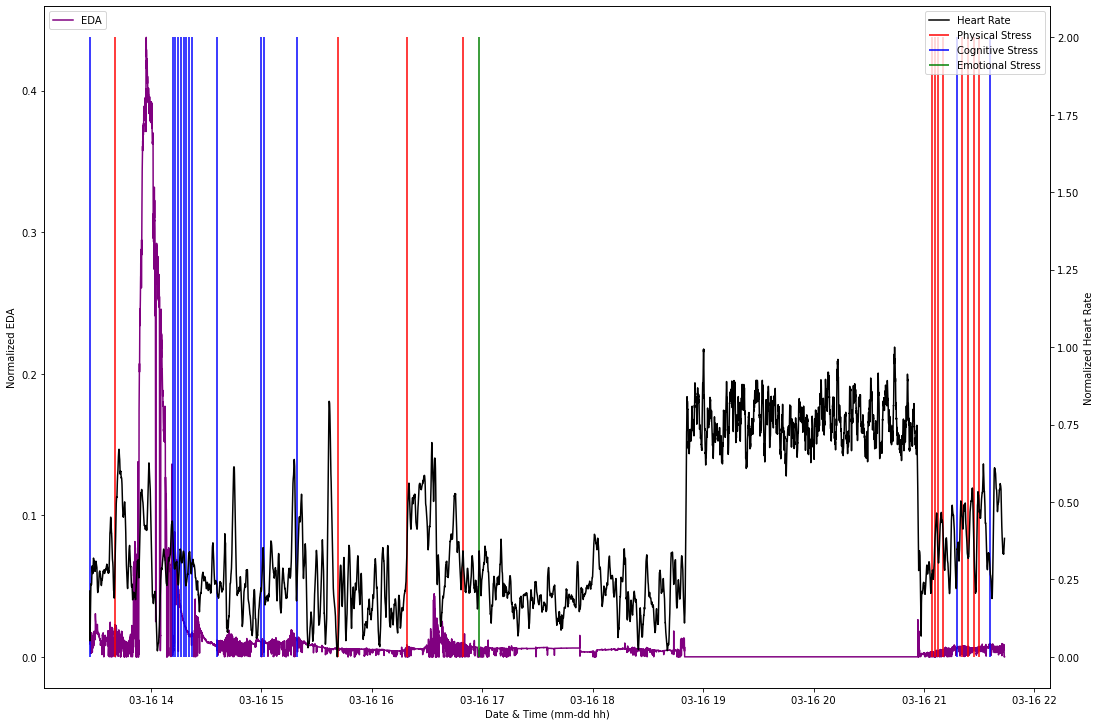

In [55]:
plot_by_date(test_data, '2022-03-16')